<a href="https://colab.research.google.com/github/ortzofi/US-Election-Analysis-With-Census-Data/blob/main/Data_Analysis_and_Prediction_Public_Version.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

Elections in the US are held for government officials at the federal, state, and local level. Depending on the level, elections take place every two, four, or six years. The two major political parties are the Democratic Party and the Republican Party. American election results have significant implications for the US and the whole world.

This project focuses on analyzing the 2020 presidential election and predicting voting behavior in the State of New York. Voting behavior in the US is affected by ethnicity, region, income, education, and many more factors. For this purpose, we train several regression models that would predict the share of vote each major party would receive. As an extra, we will try to forecast voting behavior in other states using the most successful model. 

## Data

Our model will draw on the US census data for the State of New York. Nonetheless, this analysis can be replicated with any state (even all of the US) and any geographical entity supported by the Census Bureau.

While most similar works include a statewide or countywide analysis, here we focus on smaller geographic entities - census tracts. Census tracts are small statistical subdivisions of a county that average about 4,000 inhabitants. They are subdivided only into block groups and census block. You can read more about geographic entities in the US [here](https://www.census.gov/newsroom/blogs/random-samplings/2014/07/understanding-geographic-relationships-counties-places-tracts-and-more.html).

To create the dataset, I used the 2016-2020 American Community Survey data that I had taken from the US Census Bureau using their API. Then, I merged it with the 2020 election results by census block groups dataset that was published by Harvard University. The creation of the dataset is documented in the Data Preparation notebook.

## So why is a tract-level analysis important?

The analysis of voting behavior of citizens, often takes up a huge amount of time by political parties in an attempt to realize where the support base for that party stands. As such, there are two main usecases: 

1) Political campaigns: Census tracts are smaller than counties or congressional districs. Analyzing them can therefore help political candidates target more accurate geographies. For instance: identifying more competitive tracts inside "swing districts" where candidates should allocate more resources in order to guarantee victory.

2) [Redistricting](https://www.nytimes.com/interactive/2021/11/07/us/politics/redistricting-maps-explained.html): States have to redraw the boundaries of congressional and state legislative districts. It happens every 10 years, after the decennial census, to reflect the changes in population. States gain or lose seats in Congress based on the census. 
Practically, this is often a political process in which district lines can be redrawn to favor one party over the other and protect incumbent elected officials. The intentional distortion of a map of political districts to give one party an advantage is called gerrymandering.
This project is relevant because mapmakers use similar tools and predictions for gerrymandering. Others use such tools and analyses to challenge redrawn maps as illegal gerrymanders in court.

In [ ]:
!pip install geopandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.0 MB 8.0 MB/s 
     |████████████████████████████████| 16.7 MB 38.6 MB/s 
     |████████████████████████████████| 6.3 MB 33.9 MB/s 


In [ ]:
!pip install folium

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import numpy as np

import geopandas as gpd
import folium
from folium.features import GeoJsonTooltip

import matplotlib.pyplot as plt
import seaborn as sns

from google.colab import drive
from google.colab import files

pd.options.display.max_columns = None

sns.set_theme()
sns.set_context('paper', font_scale=1.3)

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Exploratory Data Analysis

We will exclude census tracts with no population from the analysis. These tracts correspond to airports, parks, etc.

In [ ]:
path = "Your path/new_york_data.csv"

# We pass the dtype argument to prevent the geographic code columns becoming integers, thereby removing the leading zeros.
new_york_df = pd.read_csv(path, dtype={'State': str, 'County': str, 'Tract': str, 'FIPS': str}) 
ny_df = new_york_df[new_york_df['Total Population'] > 0]
ny_df

Name  Total Population   Men  \
0          Census Tract 1, Albany County, New York              2029   890   
1       Census Tract 2.01, Albany County, New York              3263  1427   
2       Census Tract 2.02, Albany County, New York              2153  1059   
3       Census Tract 3.01, Albany County, New York              3016  1347   
4       Census Tract 3.02, Albany County, New York              2931  1287   
...                                            ...               ...   ...   
5406  Census Tract 1503.01, Yates County, New York              2801  1368   
5407  Census Tract 1503.02, Yates County, New York              1935   963   
5408     Census Tract 1504, Yates County, New York              3944  1762   
5409  Census Tract 1505.01, Yates County, New York              2046   796   
5410  Census Tract 1505.02, Yates County, New York              2670  1358   

      Women  Median Age  White  Black  Native American  Asian  Latin American  \
0      1139        31.9   23.7   56.2              1.4    4.9            10.7   
1      1836        31.2   19.7   68.3              0.0    2.7             4.7   
2      1094        27.7    4.0   91.4              0.0    0.0             3.0   
3      1669        35.6   28.1   37.0              0.0   13.0            32.4   
4      1644        36.2   66.1   16.0              0.0    8.8             2.2   
...     ...         ...    ...    ...              ...    ...             ...   
5406   1433        41.5   96.6    1.2              0.0    0.2             3.7   
5407    972        48.0   97.7    0.0              0.0    0.0             0.8   
5408   2182        30.0   95.1    1.3              0.3    1.9             2.5   
5409   1250        51.6   88.4    2.6              0.0    2.5             6.4   
5410   1312        43.9   99.3    0.2              0.0    0.0             0.7   

      Not Citizen  Divorcee  High School Graduate  Bachelor's Degree  \
0             115      7.24                  31.8               11.6   
1             120      3.80                  21.1               23.5   
2              34     11.57                  39.6                6.8   
3             191     13.26                  31.0                2.4   
4             265     13.03                  27.0               14.1   
...           ...       ...                   ...                ...   
5406            8     13.07                  44.4                8.3   
5407           18     10.39                  32.2               17.6   
5408           89      5.48                  25.3               20.4   
5409           10     17.16                  43.4               10.8   
5410           11      5.13                  34.6               10.6   

      Graduate Degree  Median Household Income  Per Capita Income  \
0                 7.5                    45268              21252   
1                14.1                    37500              29740   
2                 2.5                    25290              17334   
3                 6.2                    36964              18922   
4                23.2                    42266              33695   
...               ...                      ...                ...   
5406              8.1                    60170              27466   
5407             15.4                    45000              27063   
5408             16.8                    69053              27214   
5409              5.2                    39250              27247   
5410             13.7                    67969              38403   

      Household Income 200k+  Unemployment  \
0                        1.0          10.8   
1                        4.3           3.2   
2                        2.3           9.3   
3                        1.1           6.4   
4                        4.0           3.3   
...                      ...           ...   
5406                     2.2           3.3   
5407                     3.4           1.0   
5408                     3.3

In [ ]:
ny_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5304 entries, 0 to 5410
Data columns (total 41 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   Name                                                      5304 non-null   object 
 1   Total Population                                          5304 non-null   int64  
 2   Men                                                       5304 non-null   int64  
 3   Women                                                     5304 non-null   int64  
 4   Median Age                                                5304 non-null   float64
 5   White                                                     5304 non-null   float64
 6   Black                                                     5304 non-null   float64
 7   Native American                                           5304 non-null   float64
 8   Asian             

In [ ]:
ny_df.describe()

Total Population          Men        Women   Median Age        White  \
count       5304.000000  5304.000000  5304.000000  5304.000000  5304.000000   
mean        3679.270173  1786.233786  1893.036388    40.176414    62.402074   
std         1679.426245   824.055379   896.484893     7.995453    31.151210   
min            1.000000     0.000000     0.000000     0.000000     0.000000   
25%         2443.000000  1186.000000  1238.000000    35.100000    35.200000   
50%         3488.000000  1677.000000  1785.000000    40.200000    72.500000   
75%         4668.000000  2275.000000  2402.000000    45.300000    90.200000   
max        16600.000000  7417.000000  9320.000000    85.100000   100.000000   

             Black  Native American        Asian  Latin American  Not Citizen  \
count  5304.000000      5304.000000  5304.000000     5304.000000  5304.000000   
mean     16.085690         0.458748     8.521380       17.764498   343.268854   
std      23.632583         2.607945    13.433688       19.583677   424.645764   
min       0.000000         0.000000     0.000000        0.000000     0.000000   
25%       1.100000         0.000000     0.600000        4.000000    52.000000   
50%       4.600000         0.000000     3.200000       10.500000   192.000000   
75%      19.825000         0.300000     9.700000       23.400000   476.000000   
max     100.000000        76.500000   100.000000      100.000000  3532.000000   

          Divorcee  High School Graduate  Bachelor's Degree  Graduate Degree  \
count  5304.000000           5304.000000        5304.000000      5304.000000   
mean      7.465260             26.358899          20.064103        15.517327   
std       3.954852             10.801427           9.994618        11.498266   
min       0.000000              0.000000           0.000000         0.000000   
25%       4.987500             19.475000          12.800000         7.200000   
50%       6.990000             26.700000          18.800000        12.500000   
75%       9.472500             33.600000          26.100000        21.100000   
max     100.000000            100.000000         100.000000        78.300000   

       Median Household Income  Per Capita Income  Household Income 200k+  \
count              5304.000000        5304.000000             5304.000000   
mean              77936.238311       39596.847097               10.719985   
std               38074.081460       24511.036991               11.792225   
min                2499.000000         146.000000                0.000000   
25%               52533.750000       26189.750000                2.400000   
50%               70948.000000       34064.000000                6.800000   
75%               95269.250000       45486.250000               14.625000   
max              250001.000000      320536.000000              100.000000   

       Unemployment  Occupation: Management, Business, Science, Art  \
count   5304.000000                                     5304.000000   
mean       3.626433                                       40.514480   
std        2.963053                                       16.229602   
min        0.000000                                        0.000000   
25%        1.800000                                       29.100000   
50%        3.000000                                       38.700000   
75%        4.700000                                       50.400000   
max      100.000000                                      100.000000   

       Occupation: Service  Occupation: Sales and Office  \
count          5304.000000                   5304.000000   
mean             20.424434                     21.026829   
std              10.591405                      6.680544   
min               0.000000                      0.000000   
25%              13.100000                     16.800000   
50%              18.900000                     20.600000   
75%              26.300000                     24.800000   
max             100.000000    

We begin by looking at the distribution of the variables over the tracts.

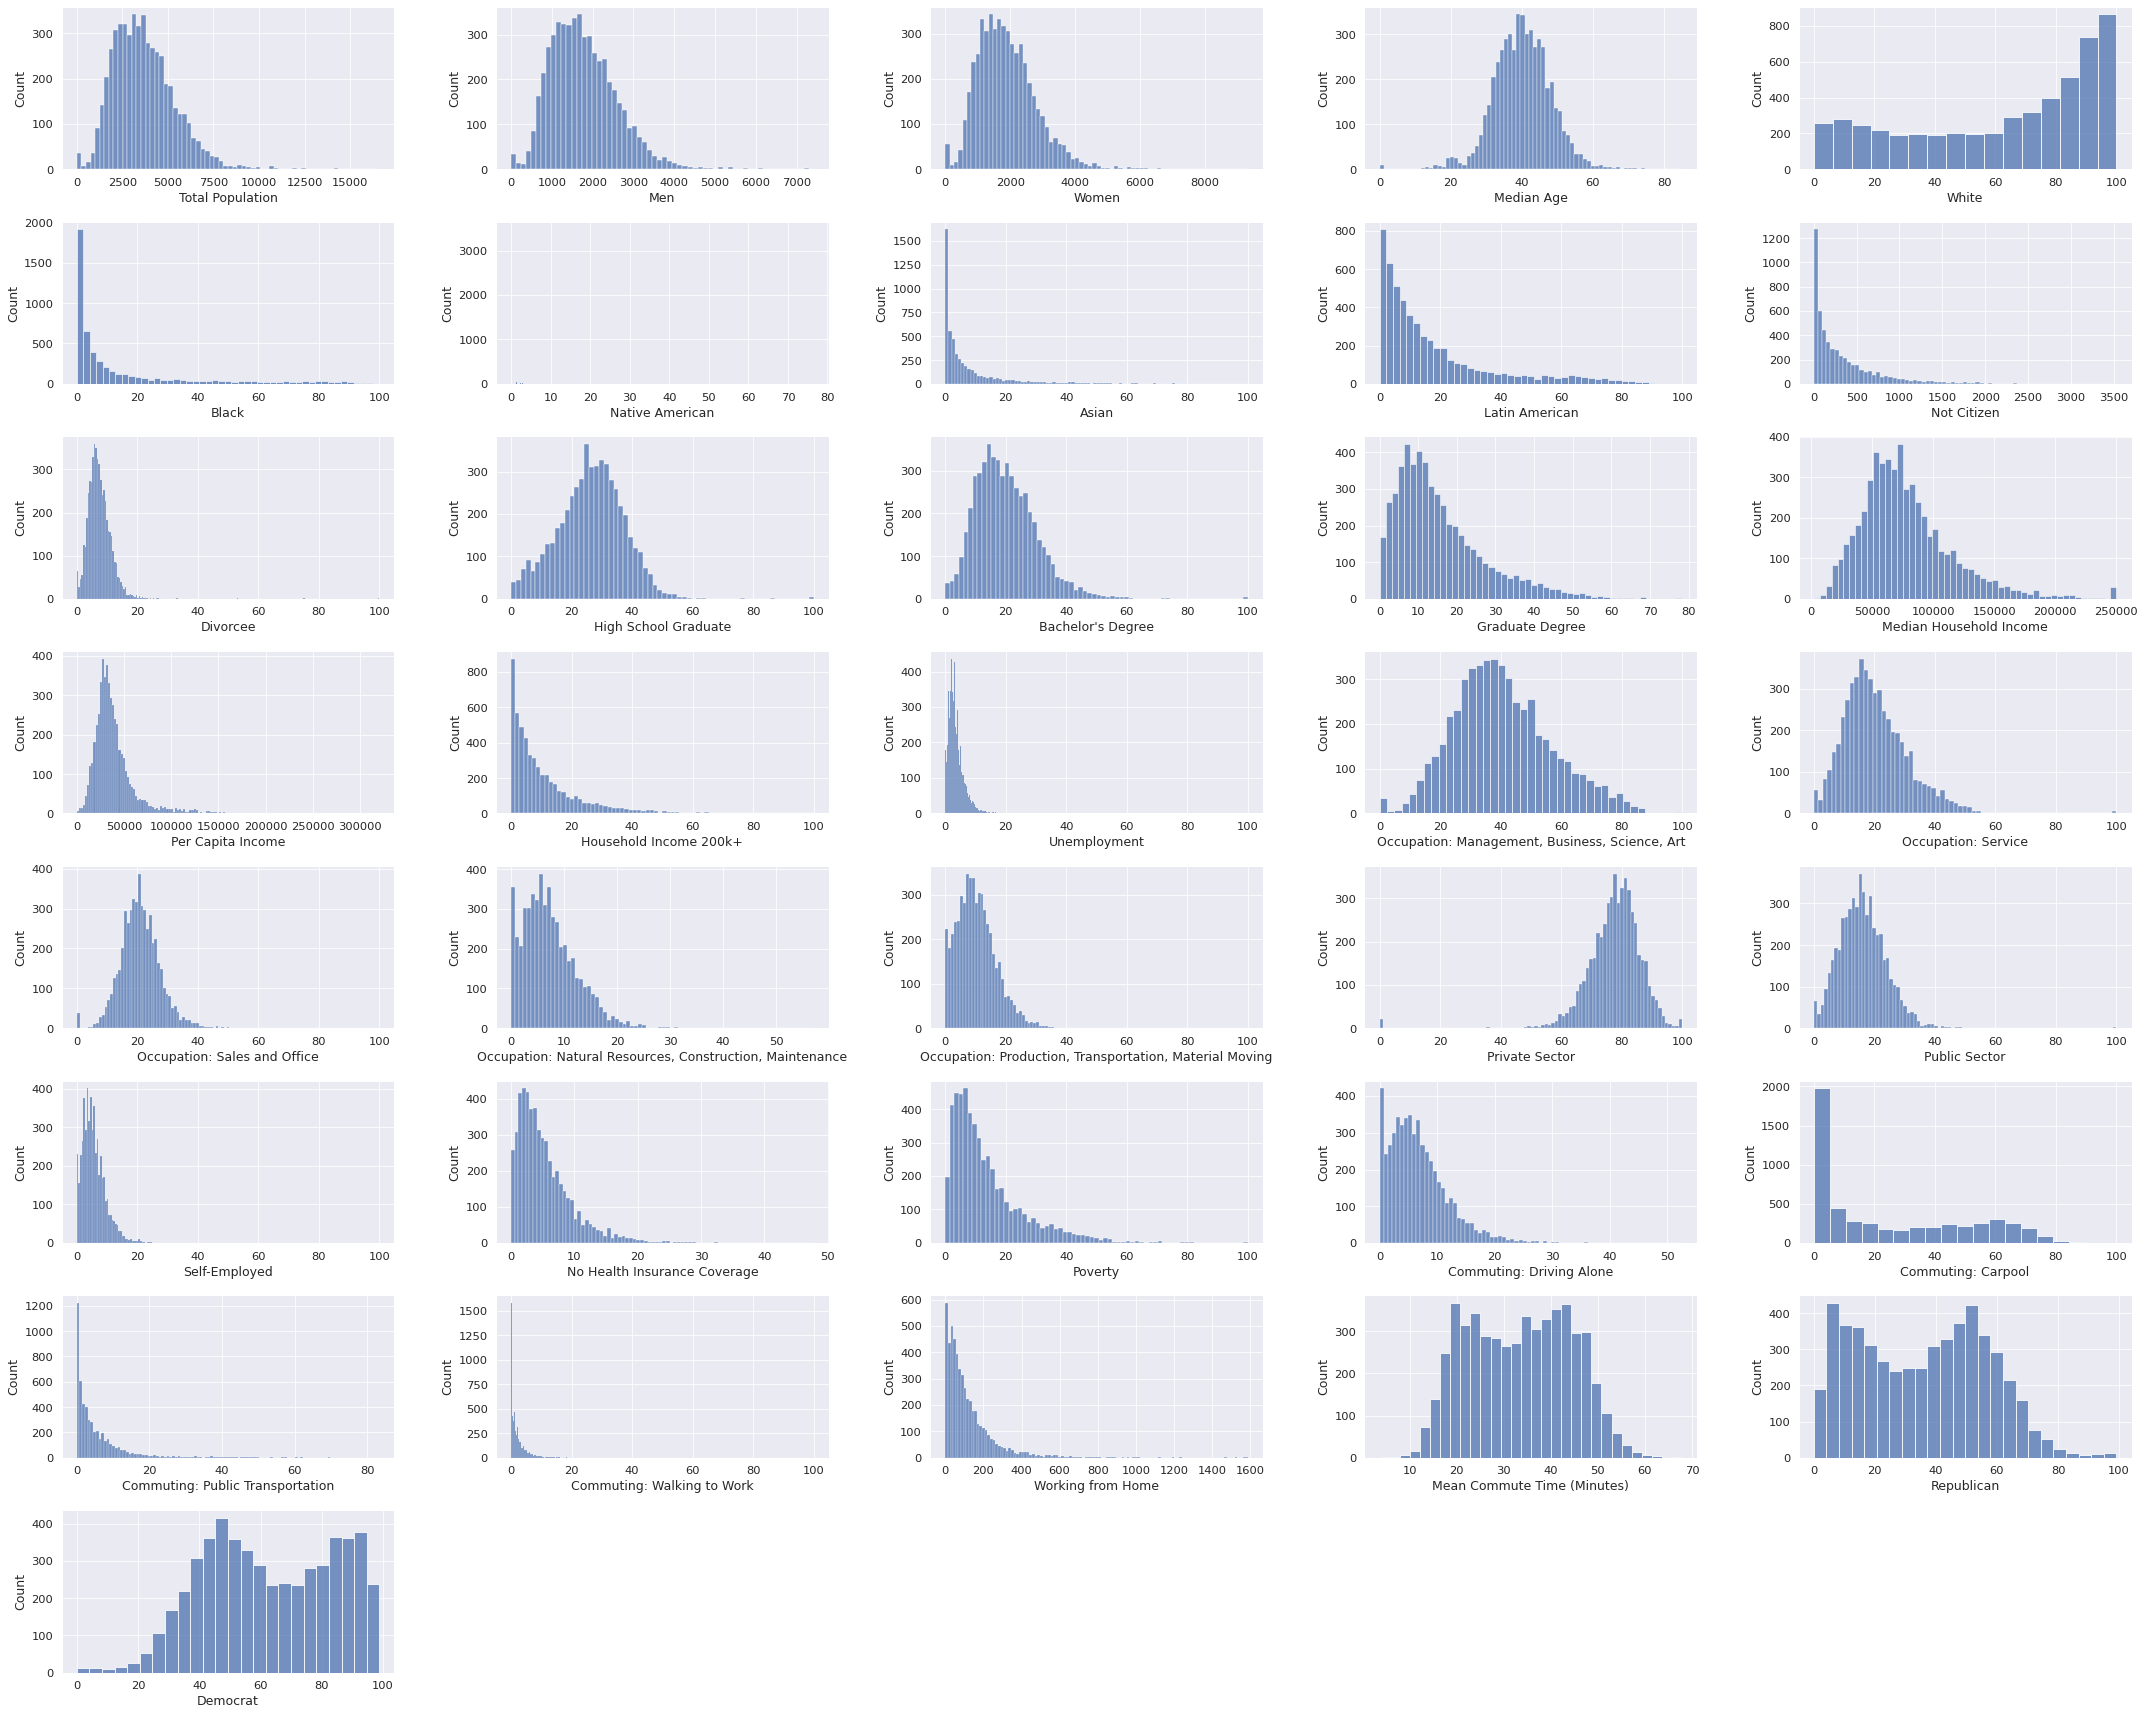

In [ ]:
fig = plt.figure(figsize=(30,24))
numeric_cols = ny_df.select_dtypes("number").columns
for i in range(len(numeric_cols)):
  fig.add_subplot(8, 5, i+1)
  sns.histplot(ny_df[numeric_cols[i]])
plt.tight_layout()
plt.show()

In this analysis, we would like to see how socio-demographic factors affect voting behavior. The target variable is the percentage of vote for the Democrats in each census tract. The Democratic Party was chosen arbitrarily; choosing the Republican Party for the analysis would yield the same results.

As we can see, the distribution of votes among the two major parties is unsurprisingly a mirror image. Votes for independent presidential candidates in the US are usually negligible.

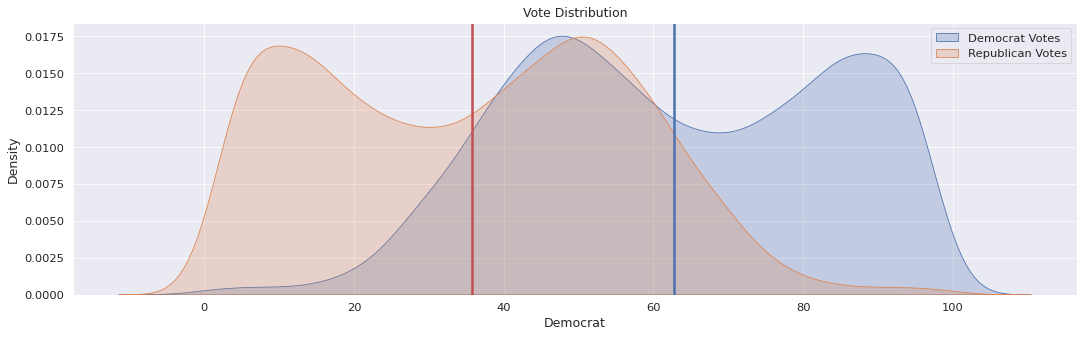

In [ ]:
fig, ax = plt.subplots(1, figsize=(18, 5))
sns.kdeplot(ny_df['Democrat'], fill=True, label="Democrat Votes", ax=ax).set(title="Vote Distribution")
sns.kdeplot(ny_df['Republican'], fill=True, label="Republican Votes", ax=ax)
ax.legend()
mean = ny_df['Democrat'].mean()
ax.axvline(x=ny_df['Democrat'].mean(), c='b', ls='-', lw=2.5)
ax.axvline(x=ny_df['Republican'].mean(), c='r', ls='-', lw=2.5)
plt.show()

The ratio between tracts in which the majority voted for the Democrats and those where most voted for the Republicans is roughly 2:1.

In [ ]:
rep_won = len(ny_df[ny_df['Republican'] > ny_df['Democrat']])
dem_won = len(ny_df[ny_df['Republican'] < ny_df['Democrat']])
print("The Republicans won in " + str(rep_won) + " census tracts in the State of New York.")
print("The Democrats won in " + str(dem_won) + " census tracts in the State of New York.")

The Republicans won in 1670 census tracts in the State of New York.
The Democrats won in 3633 census tracts in the State of New York.


Let's take a look at the relationship between some of the variables with voting for the Democratic Party.

Starting with age and income-related factors, we can see that younger people tend to vote more for the Democrats. Moreover, tracts with higher poverty and unemployment rates also tend to vote for the Democratic Party.

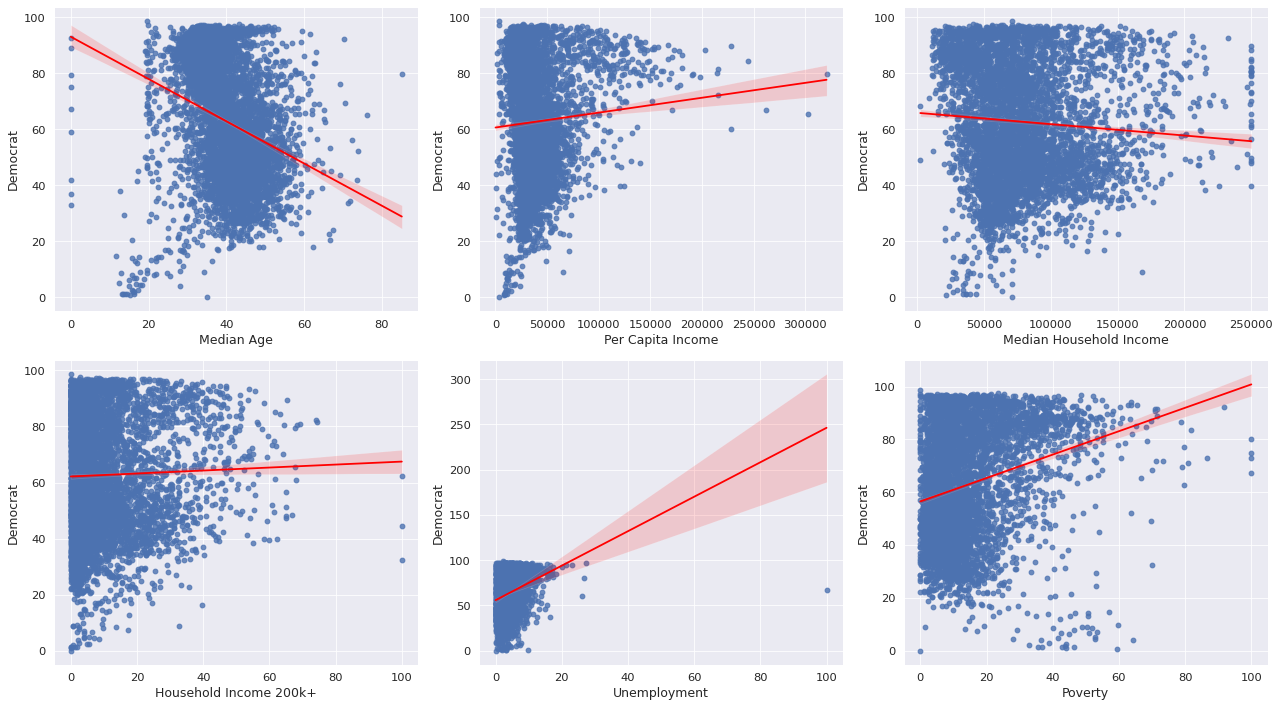

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.subplots_adjust(hspace=0.3)
sns.regplot(x='Median Age', y='Democrat', data=ny_df, line_kws={'color': 'red'}, ax=axes[0][0])
sns.regplot(x='Per Capita Income', y='Democrat', data=ny_df, line_kws={'color': 'red'}, ax=axes[0][1])
sns.regplot(x='Median Household Income', y='Democrat', data=ny_df, line_kws={'color': 'red'}, ax=axes[0][2])
sns.regplot(x='Household Income 200k+', y='Democrat', data=ny_df, line_kws={'color': 'red'}, ax=axes[1][0])
sns.regplot(x='Unemployment', y='Democrat', data=ny_df, line_kws={'color': 'red'}, ax=axes[1][1])
sns.regplot(x='Poverty', y='Democrat', data=ny_df, line_kws={'color': 'red'}, ax=axes[1][2])
plt.tight_layout()
plt.show()

Exploring commute-related variables, we notice a strong correlation between carpooling and voting for the Democrats. On the other hand, people who drive alone tend to vote for the Republican Party. A possible explanation is that Republican-voting tracts are often located in the countryside while Democratic ones are typically concentrated in the big cities.

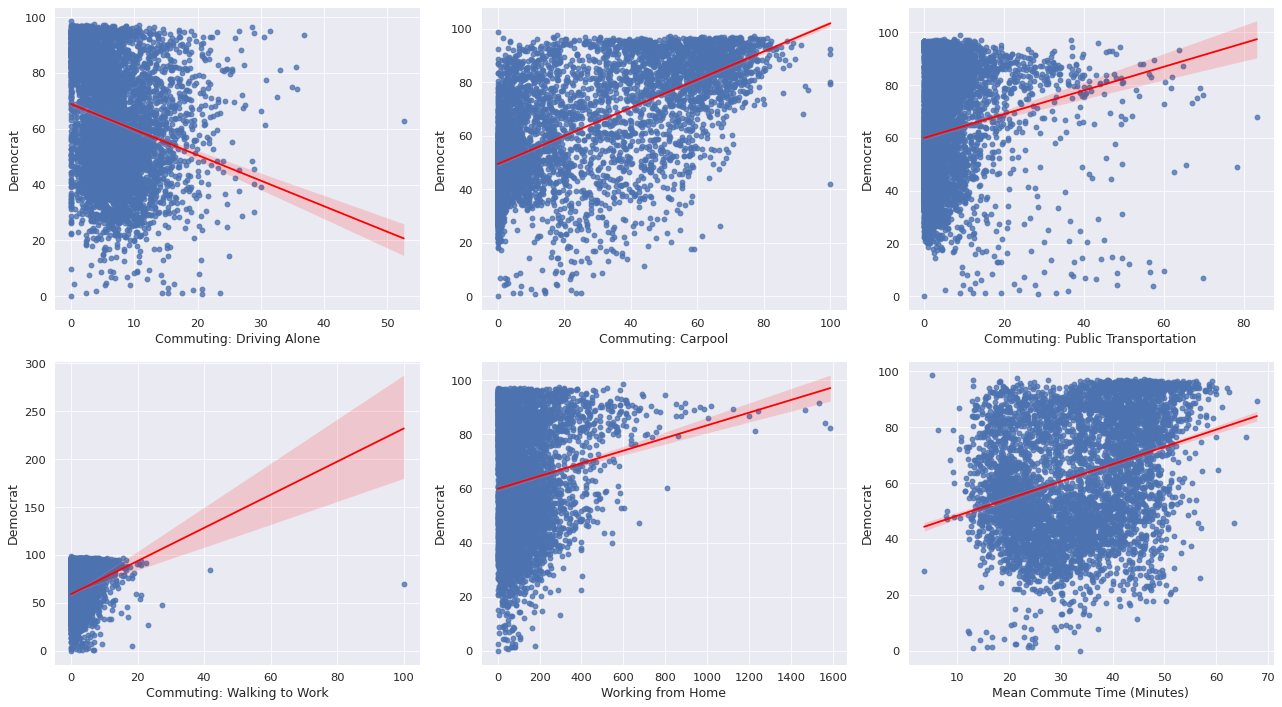

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.subplots_adjust(hspace=0.3)
sns.regplot(x='Commuting: Driving Alone', y='Democrat', data=ny_df, line_kws={'color': 'red'}, ax=axes[0][0])
sns.regplot(x='Commuting: Carpool', y='Democrat', data=ny_df, line_kws={'color': 'red'}, ax=axes[0][1])
sns.regplot(x='Commuting: Public Transportation', y='Democrat', data=ny_df, line_kws={'color': 'red'}, ax=axes[0][2])
sns.regplot(x='Commuting: Walking to Work', y='Democrat', data=ny_df, line_kws={'color': 'red'}, ax=axes[1][0])
sns.regplot(x='Working from Home', y='Democrat', data=ny_df, line_kws={'color': 'red'}, ax=axes[1][1])
sns.regplot(x='Mean Commute Time (Minutes)', y='Democrat', data=ny_df, line_kws={'color': 'red'}, ax=axes[1][2])
plt.tight_layout()
plt.show()

It is well known that race has a tremendous influence on voting behavior. We can see that tracts with a larger White population tend to vote more for the Republican Party whereas tracts with more minorities tend to vote for the Democratic Party. There is not enough data about Native Americans but the existing data suggests a similar trend.

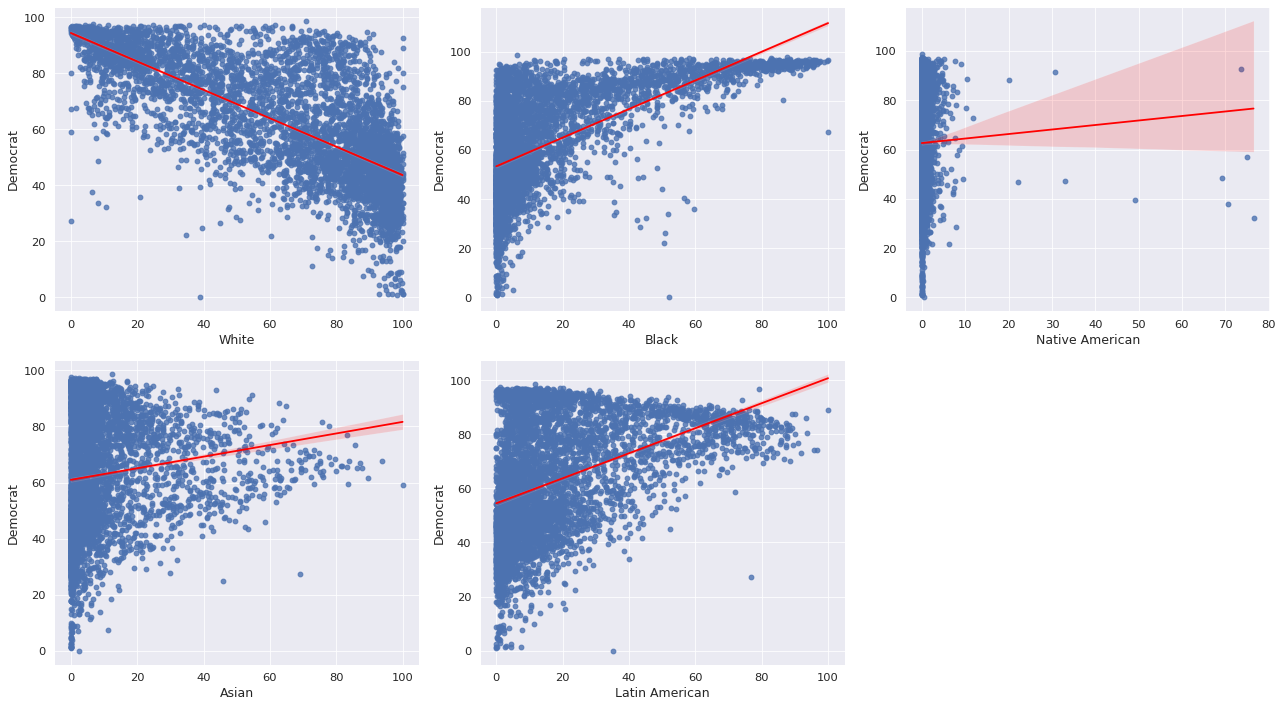

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.subplots_adjust(hspace=0.3)
sns.regplot(x='White', y='Democrat', data=ny_df, line_kws={'color': 'red'}, ax=axes[0][0])
sns.regplot(x='Black', y='Democrat', data=ny_df, line_kws={'color': 'red'}, ax=axes[0][1])
sns.regplot(x='Native American', y='Democrat', data=ny_df, line_kws={'color': 'red'}, ax=axes[0][2])
sns.regplot(x='Asian', y='Democrat', data=ny_df, line_kws={'color': 'red'}, ax=axes[1][0])
sns.regplot(x='Latin American', y='Democrat', data=ny_df, line_kws={'color': 'red'}, ax=axes[1][1])
axes[1][2].remove()
plt.tight_layout()
plt.show()

We will now explore voting behavior by the largest racial group of each census tract.


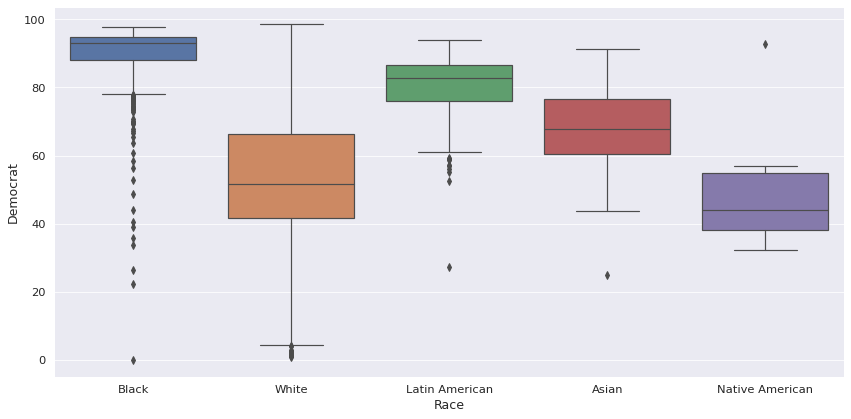

In [ ]:
dominant_race_tract = ny_df.loc[:,'White':'Latin American'].idxmax(axis=1)
largest_race_group = pd.concat([ny_df['Democrat'], dominant_race_tract], axis=1)
largest_race_group = largest_race_group.rename({0: 'Race'}, axis=1)
fig, axes = plt.subplots(figsize=(12,6))
sns.boxplot(x='Race', y='Democrat', data=largest_race_group)
plt.tight_layout()

Next, we will look at the correlation between all the variables. Note that we will use Spearman correlation (measures the strength and direction of **monotonic** association between two variables) rather than Pearson (measures the strength and direction of a **linear** association). 

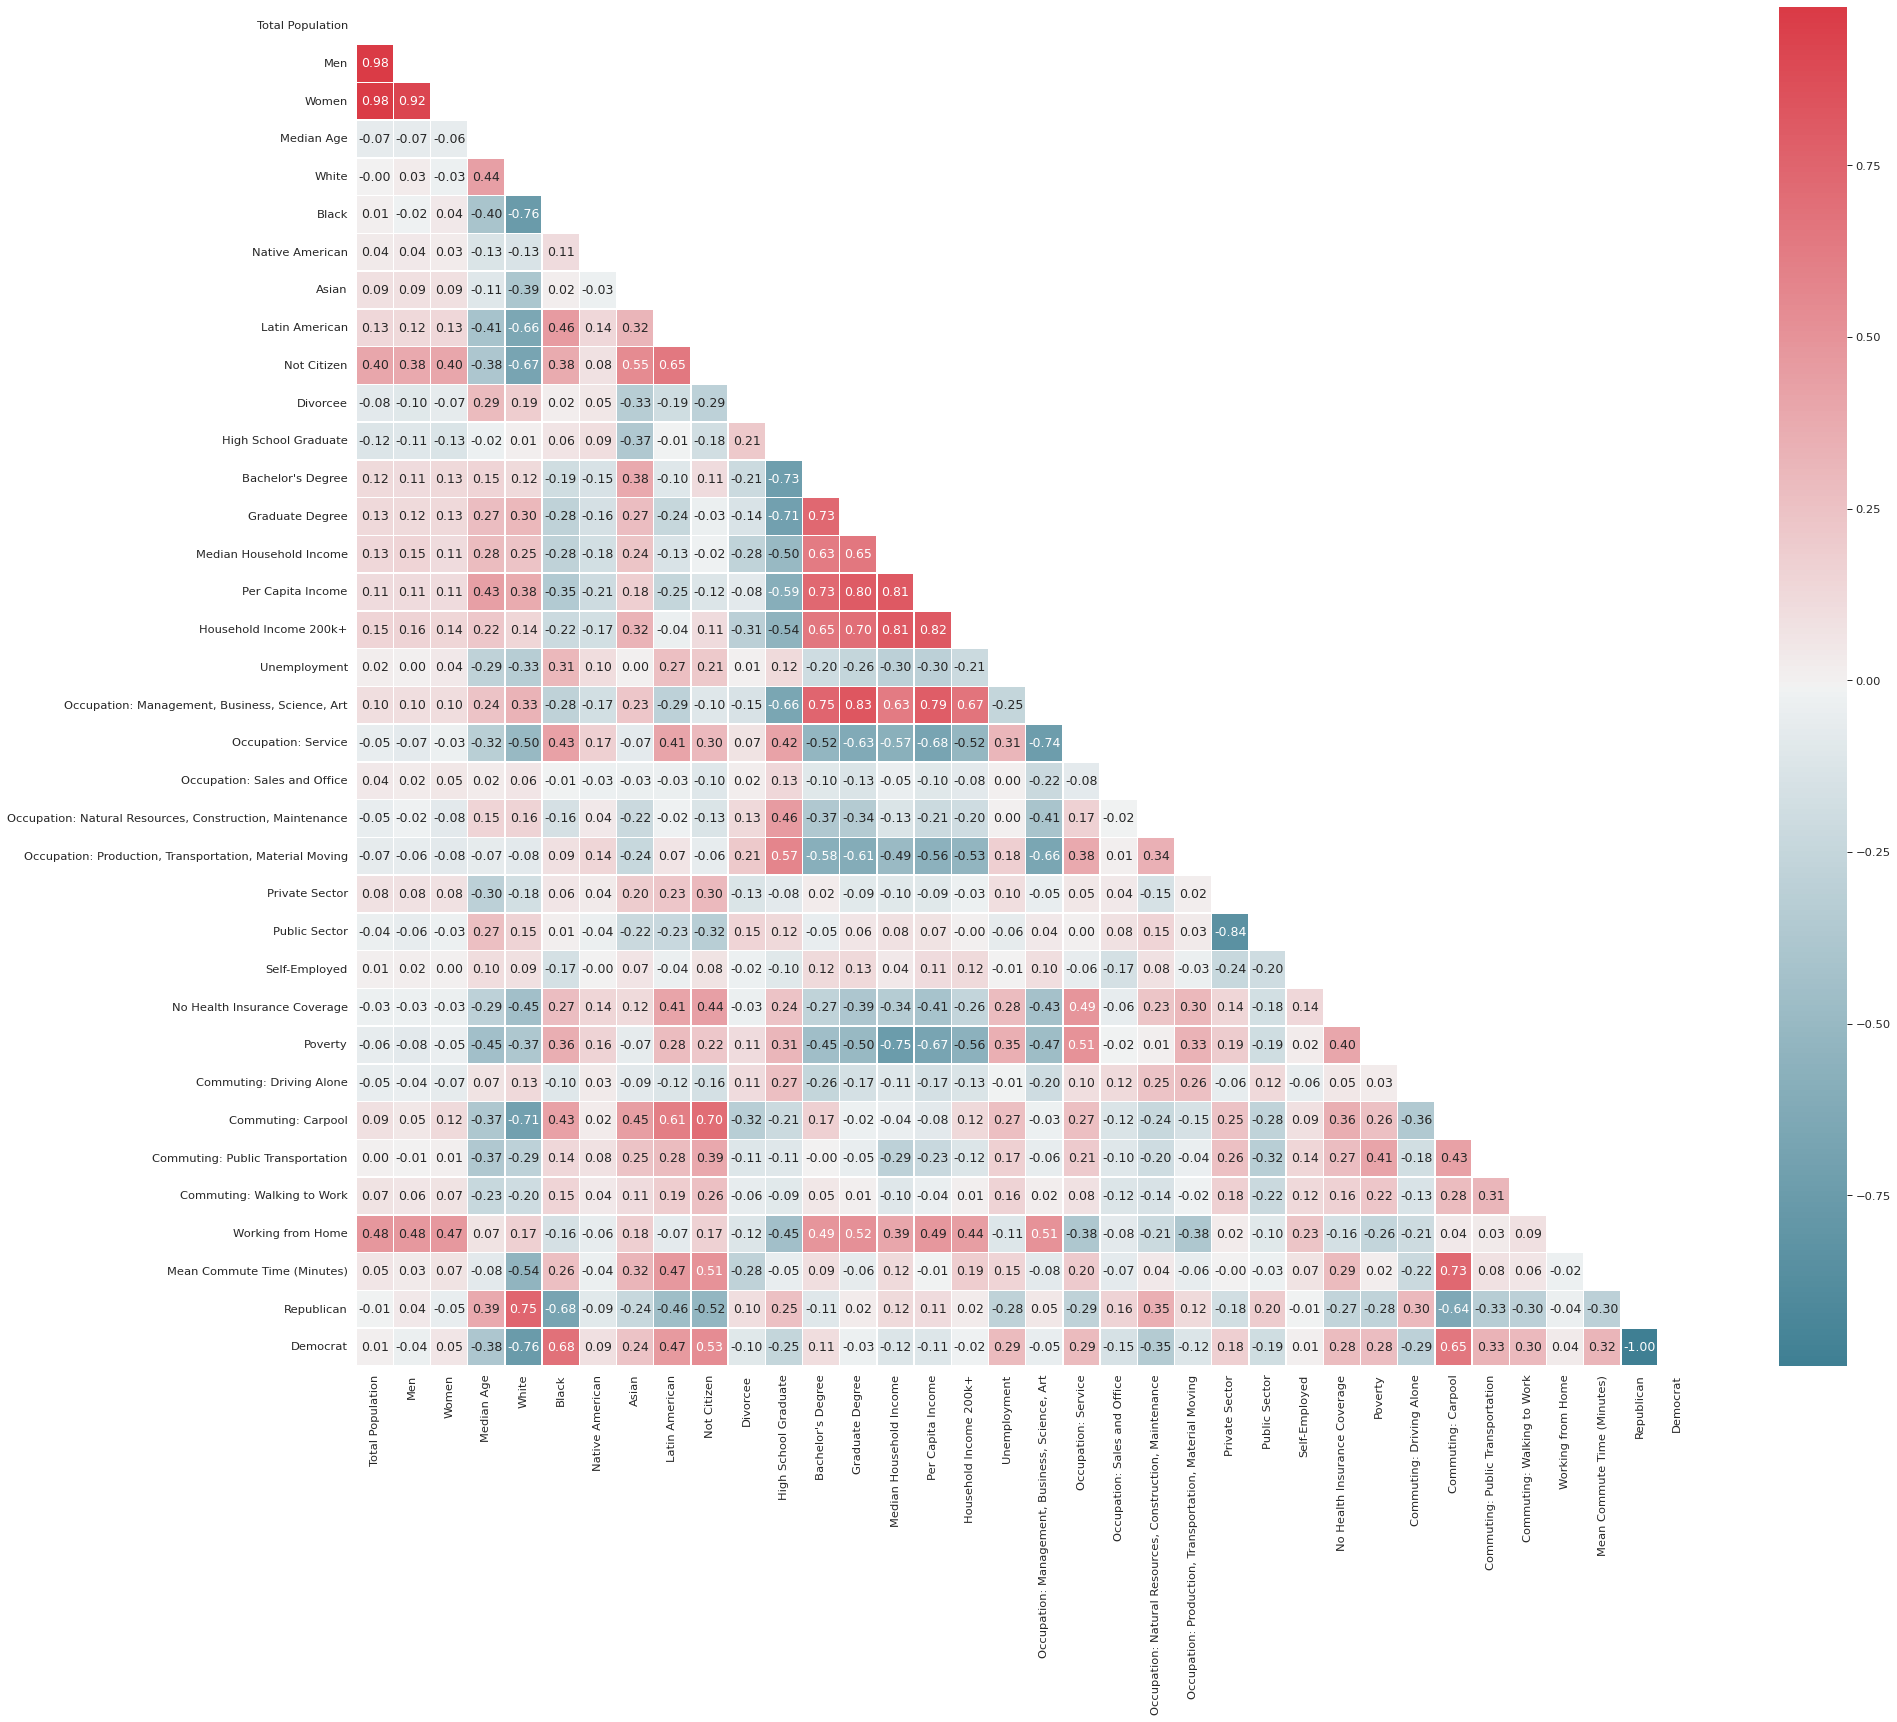

In [ ]:
corr_mat = ny_df.corr(method='spearman')
with sns.axes_style("whitegrid"):
  fig, ax = plt.subplots(figsize=(30, 25))
  mask = np.triu(np.ones_like(corr_mat))
  cmap = sns.diverging_palette(220, 10, as_cmap=True)
  sns.heatmap(corr_mat, annot=True, mask=mask, cmap=cmap, fmt='.2f', linewidths=.3, ax=ax)

# Mapping the 2020 Presidential Election Results in New York

Finally, we download the shapefile including the census tracts of New York as reflected by the 2020 Decennial Census from the [Cartographic Boundary Files section of the US census website](https://www.census.gov/geographies/mapping-files/time-series/geo/cartographic-boundary.2021.html#list-tab-7X4AAP84U4GG0RXD59). We will merge it with our dataframe and visualize the 2020 presidential election results in New York.

In [ ]:
ny_map_gdf = gpd.read_file('Your path/New York Map/cb_2021_36_tract_500k.shp')
ny_map_gdf

STATEFP COUNTYFP TRACTCE              AFFGEOID        GEOID    NAME  \
0         36      081  014700  1400000US36081014700  36081014700     147   
1         36      047  058400  1400000US36047058400  36047058400     584   
2         36      061  006900  1400000US36061006900  36061006900      69   
3         36      047  073000  1400000US36047073000  36047073000     730   
4         36      047  100400  1400000US36047100400  36047100400    1004   
...      ...      ...     ...                   ...          ...     ...   
5393      36      047  035102  1400000US36047035102  36047035102  351.02   
5394      36      071  015008  1400000US36071015008  36071015008  150.08   
5395      36      061  022302  1400000US36061022302  36061022302  223.02   
5396      36      047  034901  1400000US36047034901  36047034901  349.01   
5397      36      059  982100  1400000US36059982100  36059982100    9821   

                 NAMELSAD STUSPS       NAMELSADCO STATE_NAME LSAD    ALAND  \
0        Census Tract 147     NY    Queens County   New York   CT   147950   
1        Census Tract 584     NY     Kings County   New York   CT   188225   
2         Census Tract 69     NY  New York County   New York   CT   220486   
3        Census Tract 730     NY     Kings County   New York   CT   185122   
4       Census Tract 1004     NY     Kings County   New York   CT   132054   
...                   ...    ...              ...        ...  ...      ...   
5393  Census Tract 351.02     NY     Kings County   New York   CT    93117   
5394  Census Tract 150.08     NY    Orange County   New York   CT   375968   
5395  Census Tract 223.02     NY  New York County   New York   CT    60089   
5396  Census Tract 349.01     NY     Kings County   New York   CT    69957   
5397    Census Tract 9821     NY    Nassau County   New York   CT  2792616   

      AWATER                                           geometry  
0          0  POLYGON ((-73.91370 40.76548, -73.91210 40.764...  
1          0  POLYGON ((-73.96103 40.59616, -73.95978 40.596...  
2     284380  POLYGON ((-74.02064 40.73039, -74.02006 40.732...  
3          0  POLYGON ((-73.93345 40.62570, -73.93149 40.625...  
4          0  POLYGON ((-73.90735 40.63083, -73.90415 40.632...  
...      ...                                                ...  
5393       0  POLYGON ((-73.93406 40.66717, -73.93389 40.668...  
5394       0  POLYGON ((-74.16957 41.34101, -74.16901 41.342...  
5395   97199  POLYGON ((-73.96571 40.82370, -73.96509 40.824...  
5396       0  POLYGON ((-73.93095 40.67058, -73.93087 40.671...  
5397       0  POLYGON ((-73.57637 40.80460, -73.57697 40.805...  

[5398 rows x 14 columns]

Doing a left merge to include all the tracts, even if they have no population. Note that the each number in the GEOID column is in fact a FIPS code.

In [ ]:
ny_data_gdf = ny_map_gdf.merge(ny_df, how="left", left_on="GEOID", right_on="FIPS")
ny_data_gdf.head()

STATEFP COUNTYFP TRACTCE              AFFGEOID        GEOID  NAME  \
0      36      081  014700  1400000US36081014700  36081014700   147   
1      36      047  058400  1400000US36047058400  36047058400   584   
2      36      061  006900  1400000US36061006900  36061006900    69   
3      36      047  073000  1400000US36047073000  36047073000   730   
4      36      047  100400  1400000US36047100400  36047100400  1004   

            NAMELSAD STUSPS       NAMELSADCO STATE_NAME LSAD   ALAND  AWATER  \
0   Census Tract 147     NY    Queens County   New York   CT  147950       0   
1   Census Tract 584     NY     Kings County   New York   CT  188225       0   
2    Census Tract 69     NY  New York County   New York   CT  220486  284380   
3   Census Tract 730     NY     Kings County   New York   CT  185122       0   
4  Census Tract 1004     NY     Kings County   New York   CT  132054       0   

                                            geometry  \
0  POLYGON ((-73.91370 40.76548, -73.91210 40.764...   
1  POLYGON ((-73.96103 40.59616, -73.95978 40.596...   
2  POLYGON ((-74.02064 40.73039, -74.02006 40.732...   
3  POLYGON ((-73.93345 40.62570, -73.93149 40.625...   
4  POLYGON ((-73.90735 40.63083, -73.90415 40.632...   

                                         Name  Total Population     Men  \
0   Census Tract 147, Queens County, New York            2712.0  1256.0   
1    Census Tract 584, Kings County, New York            3530.0  1467.0   
2  Census Tract 69, New York County, New York            2341.0  1224.0   
3    Census Tract 730, Kings County, New York            2526.0  1063.0   
4   Census Tract 1004, Kings County, New York            2642.0  1049.0   

    Women  Median Age  White  Black  Native American  Asian  Latin American  \
0  1456.0        35.9   72.4    5.3              0.6   13.2             9.1   
1  2063.0        42.0   67.6    5.1              0.0   24.5             4.9   
2  1117.0        36.1   86.2    0.7              0.0    8.5             6.8   
3  1463.0        39.3   12.8   82.5              0.0    0.0            10.8   
4  1593.0        40.6    5.7   90.2              0.0    0.6             2.4   

   Not Citizen  Divorcee  High School Graduate  Bachelor's Degree  \
0        215.0      5.75                  20.2               29.6   
1        459.0      8.50                  22.6               23.8   
2        176.0      5.77                   5.0               51.0   
3        173.0      7.56                  20.4               34.5   
4        288.0      5.64                  34.5               16.5   

   Graduate Degree  Median Household Income  Per Capita Income  \
0             19.1                  80871.0            46354.0   
1             21.5                  63324.0            30597.0   
2             34.8                 214063.0           157002.0   
3             13.1                 112625.0            37588.0   
4             15.6                  70769.0            32341.0   

   Household Income 200k+  Unemployment  \
0                     4.4           4.3   
1                     6.8           5.7   
2                    53.6           3.5   
3                    12.3           4.1   
4                    12.7           1.8   

   Occupation: Management, Business, Science, Art  Occupation: Service  \
0                                            52.6                 15.1   
1                                            38.6                 22.6   
2                                            68.9                  9.6   
3                                            39.1                 23.4   
4                                            38.6                 28.7   

   Occupation: Sales and Office  \
0                          21.8   
1                          19.8   
2                          19.7   
3                          31.7   
4                          17.0   

   Occupation: Natural Resources, Construction, Maintenance  \
0                                        

In [ ]:
ny_data_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 5398 entries, 0 to 5397
Data columns (total 55 columns):
 #   Column                                                    Non-Null Count  Dtype   
---  ------                                                    --------------  -----   
 0   STATEFP                                                   5398 non-null   object  
 1   COUNTYFP                                                  5398 non-null   object  
 2   TRACTCE                                                   5398 non-null   object  
 3   AFFGEOID                                                  5398 non-null   object  
 4   GEOID                                                     5398 non-null   object  
 5   NAME                                                      5398 non-null   object  
 6   NAMELSAD                                                  5398 non-null   object  
 7   STUSPS                                                    5398 non-null   object  
 8   

Let's visualize the data and look at the map to see the share of vote and the demographic composition of each census tract.

In [ ]:
election_results_map = folium.Map(location=[43.00, -75.00], zoom_start=7)

#Choropleth map
election = folium.Choropleth(
    geo_data=ny_data_gdf,
    name="Election Results",
    data=ny_data_gdf,
    columns= ["GEOID","Democrat"],
    key_on="feature.properties.GEOID",
    fill_color="RdBu",
    fill_opacity=0.7,
    line_opacity=0.2,
    bins=[0, 25, 40, 50, 60, 75, 100],
    nan_fill_color="White",
    legend_name="Percentage of vote for the Democratic Party").add_to(election_results_map)

#Tooltip
folium.features.GeoJson(
                    data=ny_data_gdf,
                    name='Election Results',
                    smooth_factor=2,
                    style_function=lambda x: {'color':'black','fillColor':'transparent','weight':0.5},
                    tooltip=folium.features.GeoJsonTooltip(
                        fields=['Name',
                                'Democrat',
                                'Republican',
                                'Total Population',
                                'White',
                                'Black',
                                'Latin American',
                                'Asian',
                                'Native American',
                               ],
                        aliases=["Location:",
                                 "<br>% Democrat Votes:",
                                 "% Republican Votes:",
                                 "<br>Total Population:",
                                 "White:",
                                 "Black:",
                                 "Latin American:",
                                 "Asian:",
                                 "Native American",
                                ], 
                        localize=True,
                        sticky=False,
                        labels=True,
                        style="""
                            background-color: #F0EFEF;
                            border: 2px solid black;
                            border-radius: 3px;
                            box-shadow: 3px;
                        """,
                        max_width=800,),
                            highlight_function=lambda x: {'weight':3,'fillColor':'grey'},
                        ).add_to(election) 

folium.LayerControl().add_to(election_results_map)

The Folium map is unfortunately too large to display here so here is a picture of it. Please look at the file "NY_Election_Results_Visualization.html" for the interactive map.

In [ ]:
election_results_map.save("NY_Election_Results_Visualization.html")
files.download("NY_Election_Results_Visualization.html")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

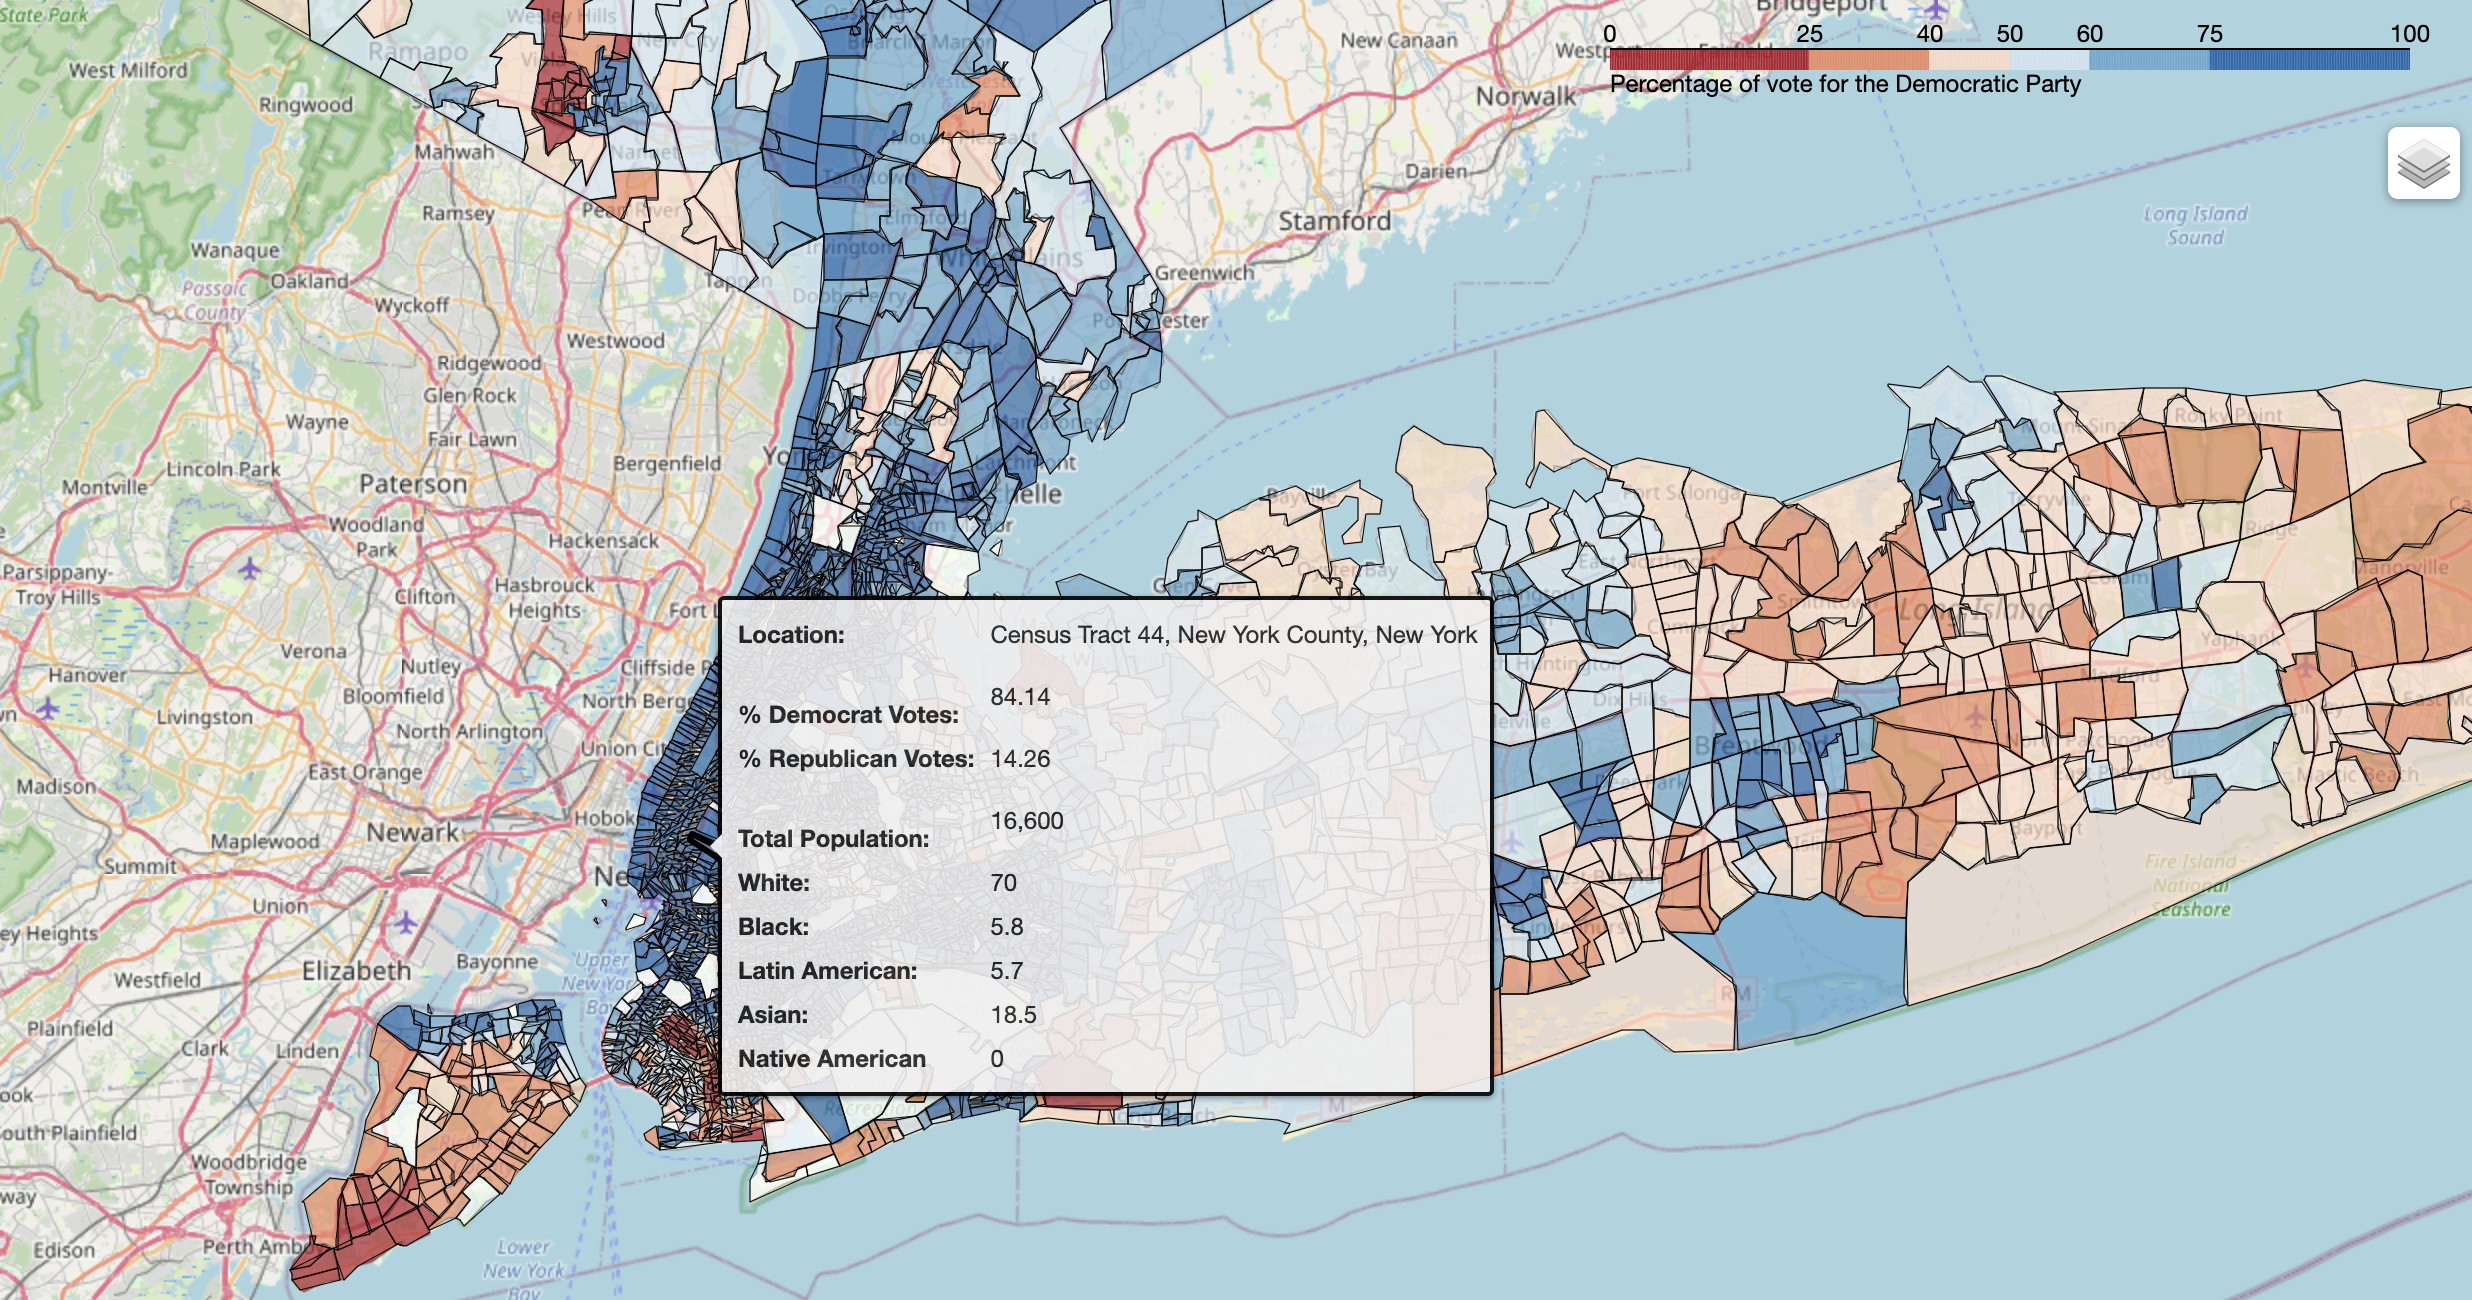

# Prediction

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import KFold, cross_val_score, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler

import xgboost as xgb
import lightgbm as lgb

We split the data into training and test sets, scale them, and define some utility functions, including a 5-fold cross validation.

There will be no feature selection as trying it resulted in lower-performing models.

In [ ]:
X = ny_df._get_numeric_data()
y = ny_df['Democrat']
X.drop(['Democrat', 'Republican'], axis=1, inplace=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [ ]:
numeric_cols = X.select_dtypes("number").columns

sc = StandardScaler()
X_train[numeric_cols] = sc.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = sc.transform(X_test[numeric_cols])

In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=42).get_n_splits(X)

def cross_validate(model):
  scores = -cross_val_score(model, X_train, y_train, scoring="neg_root_mean_squared_error", cv=kf, n_jobs=-1)
  return scores.mean(), scores.min(), scores.max()

def evaluate(true_vals, predicted):
  mae = mean_absolute_error(true_vals, predicted)
  mse = mean_squared_error(true_vals, predicted)
  rmse = mean_squared_error(true_vals, predicted, squared=False)
  r2 = r2_score(true_vals, predicted)

  return mae, mse, rmse, r2

def model_training_and_testing(model):
  model.fit(X_train, y_train)
  train_pred = model.predict(X_train)
  test_pred = model.predict(X_test)

  train_scores = evaluate(y_train, train_pred)
  test_scores = evaluate(y_test, test_pred)

  return train_scores, test_scores

def print_evaluation(mae, mse, rmse, r2):
  print('MAE:', mae)
  print('MSE:', mse)
  print('RMSE:', rmse)
  print('R2 Score:', r2)
  print('-----------------------------------')

def print_results(train_scores, test_scores, cv_scores):
  print('Cross Validation Results:\n-----------------------------------')
  print('Mean RMSE:', cv_scores[0])
  print('Min RMSE:', cv_scores[1])
  print('Max RMSE:', cv_scores[2])
  print('-----------------------------------')
  print('Training set evaluation:\n-----------------------------------')
  print_evaluation(*train_scores)
  print('Test set evaluation:\n-----------------------------------')
  print_evaluation(*test_scores)

In [ ]:
results_cols = ['Model', 'MAE', 'MSE', 'RMSE', 'R2', 'CV (Mean)', 'CV (Min)', 'CV (Max)']
results_df = pd.DataFrame(columns=results_cols)

def add_results_row(model_name, test_scores, cv_scores):
  mae, mse, rmse, r2 = test_scores
  cv_mean, cv_min, cv_max = cv_scores

  new_row = [model_name, *test_scores, *cv_scores]

  results_df.loc[len(results_df)] = new_row

We will start with a simple linear regression model which will be our benchmark.

In [ ]:
lm = LinearRegression()

cv_scores_lm = cross_validate(lm)

train_scores_lm, test_scores_lm = model_training_and_testing(lm)

print_results(train_scores_lm, test_scores_lm, cv_scores_lm)

add_results_row('Linear Regression', test_scores_lm, cv_scores_lm)

Cross Validation Results:
-----------------------------------
Mean RMSE: 9.092323260011037
Min RMSE: 8.412458248182267
Max RMSE: 9.825300124266512
-----------------------------------
Training set evaluation:
-----------------------------------
MAE: 6.706047425339511
MSE: 79.090809862581
RMSE: 8.89330140401083
R2 Score: 0.8277214328143889
-----------------------------------
Test set evaluation:
-----------------------------------
MAE: 6.6425006789602525
MSE: 82.70858988655773
RMSE: 9.09442630882002
R2 Score: 0.8081706523938348
-----------------------------------


Next, random forest regression.

In [ ]:
rf = RandomForestRegressor(random_state=42)

cv_scores_rf = cross_validate(rf)

train_scores_rf, test_scores_rf = model_training_and_testing(rf)

print_results(train_scores_rf, test_scores_rf, cv_scores_rf)

add_results_row('Random Forest Regressor', test_scores_rf, cv_scores_rf)

Cross Validation Results:
-----------------------------------
Mean RMSE: 8.014868094778162
Min RMSE: 7.548870571235944
Max RMSE: 8.539536838215419
-----------------------------------
Training set evaluation:
-----------------------------------
MAE: 2.0566392646712233
MSE: 8.88780482259251
RMSE: 2.9812421610114987
R2 Score: 0.9806402503284263
-----------------------------------
Test set evaluation:
-----------------------------------
MAE: 5.505516870876533
MSE: 63.38104160488218
RMSE: 7.961221112673745
R2 Score: 0.8529978098001667
-----------------------------------


Doing a random search with Gridsearch, we will try to fine tune and optimize the random forest regression to some extent. The best model will be taken for further evaluation.

In [ ]:
rf = RandomForestRegressor(random_state=42)

#Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 500, num = 5)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 30, num = 6)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 15, 100]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 5, 10]

params_grid_rf = {
    'n_estimators': n_estimators,
    'max_features': max_features,
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf
}

random_rf = RandomizedSearchCV(rf, param_distributions=params_grid_rf, scoring='neg_root_mean_squared_error', random_state=42, cv=kf, n_iter=10, n_jobs=-1)

random_rf.fit(X_train, y_train)

print(random_rf.best_estimator_)
print(random_rf.best_score_)
print(random_rf.best_params_)

RandomForestRegressor(min_samples_leaf=2, min_samples_split=10,
                      n_estimators=400, random_state=42)
-7.9982551499559476
{'n_estimators': 400, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': None}


In [ ]:
rf = RandomForestRegressor(min_samples_leaf=2, min_samples_split=10,
                      n_estimators=400, random_state=42)

cv_scores_rf = cross_validate(rf)

train_scores_rf, test_scores_rf = model_training_and_testing(rf)

print_results(train_scores_rf, test_scores_rf, cv_scores_rf)

add_results_row('Random Forest Regressor (Optimized)', test_scores_rf, cv_scores_rf)

Cross Validation Results:
-----------------------------------
Mean RMSE: 7.9982551499559476
Min RMSE: 7.512400977312185
Max RMSE: 8.47250793120083
-----------------------------------
Training set evaluation:
-----------------------------------
MAE: 2.7260812216679313
MSE: 16.21142246623184
RMSE: 4.026341076738512
R2 Score: 0.9646876718119889
-----------------------------------
Test set evaluation:
-----------------------------------
MAE: 5.440073744602796
MSE: 62.81077731495298
RMSE: 7.925325060522942
R2 Score: 0.8543204466248334
-----------------------------------


The optimized random forest achieved a similar result. We could have optimized it better, but we would rather move on to try some more promising models.

Now, we will look at two high-performing gradient boosting regression models: XGBoost and LightGBM. We will compare the performance of an optimized and a non-optimized version of each.

In [ ]:
xgbr = xgb.XGBRegressor()

cv_scores_xgbr = cross_validate(xgbr)

train_scores_xgbr, test_scores_xgbr = model_training_and_testing(xgbr)

print_results(train_scores_xgbr, test_scores_xgbr, cv_scores_xgbr)

add_results_row('XGBRegressor', test_scores_xgbr, cv_scores_xgbr)

[11:54:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Cross Validation Results:
-----------------------------------
Mean RMSE: 8.081426288162454
Min RMSE: 7.607095214311302
Max RMSE: 8.548482220040038
-----------------------------------
Training set evaluation:
-----------------------------------
MAE: 4.94190362072373
MSE: 43.97948285563638
RMSE: 6.6317028624355885
R2 Score: 0.9042022416372065
-----------------------------------
Test set evaluation:
-----------------------------------
MAE: 5.653667574288371
MSE: 66.9680282955442
RMSE: 8.183399556146835
R2 Score: 0.8446783677967973
-----------------------------------


In [ ]:
params_grid_xgb = {
    'objective': ['reg:squarederror'],
    'n_estimators': [700],
    'learning_rate': [0.05],
    'max_depth': [6],
    'min_child_weight': [1, 5, 10, 15, 20, 25],
    'colsample_bytree': [0.8],
    'colsample_bylevel': [0.7],
    'subsample': [1],
    'gamma': [1],
    'reg_alpha': [0],
    'seed': [0]
    }

fit_params={"early_stopping_rounds": 30,
            "eval_metric" : "rmse", 
            "eval_set" : [(X_test, y_test)]}

xgbr = xgb.XGBRegressor()

gs = GridSearchCV(xgbr, params_grid_xgb, scoring='neg_root_mean_squared_error', cv=kf, verbose=3, n_jobs=-1)

gs.fit(X_train, y_train, **fit_params)

print(gs.best_estimator_)
print(gs.best_score_)
print(gs.best_params_)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[0]	validation_0-rmse:62.4448
Will train until validation_0-rmse hasn't improved in 30 rounds.
[1]	validation_0-rmse:59.4223
[2]	validation_0-rmse:56.5574
[3]	validation_0-rmse:53.814
[4]	validation_0-rmse:51.2267
[5]	validation_0-rmse:48.7687
[6]	validation_0-rmse:46.4311
[7]	validation_0-rmse:44.2114
[8]	validation_0-rmse:42.117
[9]	validation_0-rmse:40.128
[10]	validation_0-rmse:38.2316
[11]	validation_0-rmse:36.4319
[12]	validation_0-rmse:34.7261
[13]	validation_0-rmse:33.1005
[14]	validation_0-rmse:31.5813
[15]	validation_0-rmse:30.1371
[16]	validation_0-rmse:28.7598
[17]	validation_0-rmse:27.4557
[18]	validation_0-rmse:26.2422
[19]	validation_0-rmse:25.077
[20]	validation_0-rmse:23.9705
[21]	validation_0-rmse:22.9193
[22]	validation_0-rmse:21.9366
[23]	validation_0-rmse:21.0096
[24]	validation_0-rmse:20.1309
[25]	validation_0-rmse:19.2888
[26]	validation_0-rmse:18.5043
[27]	validation_0-rmse:17.7655
[28]	validation_0-rms

In [ ]:
xgbr = xgb.XGBRegressor(colsample_bylevel=0.7, colsample_bytree=0.8, gamma=1,
             learning_rate=0.05, max_depth=6, min_child_weight=15,
             n_estimators=700, objective='reg:squarederror', seed=0)

eval_set = [(X_train, y_train), (X_test, y_test)]

xgbr.fit(X_train, y_train, eval_metric='rmse', eval_set=eval_set, verbose=False, early_stopping_rounds=30)
train_pred_xgbr = xgbr.predict(X_train)
test_pred_xgbr = xgbr.predict(X_test)
train_scores_xgbr = evaluate(y_train, train_pred_xgbr)
test_scores_xgbr = evaluate(y_test, test_pred_xgbr)

cv_scores_xgbr = cross_validate(xgbr)

print_results(train_scores_xgbr, test_scores_xgbr, cv_scores_xgbr)

add_results_row('XGBRegressor (Optimized)', test_scores_xgbr, cv_scores_xgbr)

Cross Validation Results:
-----------------------------------
Mean RMSE: 7.357023162435621
Min RMSE: 7.062809128380379
Max RMSE: 7.802732430786522
-----------------------------------
Training set evaluation:
-----------------------------------
MAE: 1.8157232448320302
MSE: 6.370844043543459
RMSE: 2.524053098400162
R2 Score: 0.9861227886591167
-----------------------------------
Test set evaluation:
-----------------------------------
MAE: 5.065001886998787
MSE: 52.530293812413056
RMSE: 7.247778543278834
R2 Score: 0.8781643840692159
-----------------------------------


That is a better result!

We will now plot the RMSE on the train and the test sets and look at the feature importance of the model.

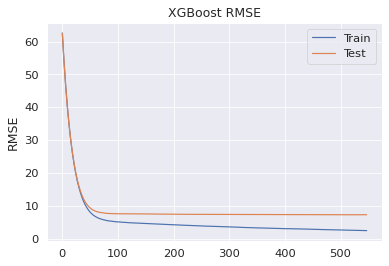

In [ ]:
xgbr_results = xgbr.evals_result()
epochs = len(xgbr_results['validation_0']['rmse'])
x_axis = range(0, epochs)
fig, ax = plt.subplots()
ax.plot(x_axis, xgbr_results['validation_0']['rmse'], label='Train')
ax.plot(x_axis, xgbr_results['validation_1']['rmse'], label='Test')
ax.legend()
plt.ylabel('RMSE')
plt.title('XGBoost RMSE')
plt.show()

This feature importance table makes a lot of sense. As we have seen in the correlation heatmap, race, age and commute options are highly correlated with voting. As such, White, Black and Carpool are the most dominant features. 

The choice of the graduate degree feature is much less obvious and very surprising as it has no correlation with voting in our data (although we know that more educated people tend to vote for the Democratic Party, our data does not really support it).

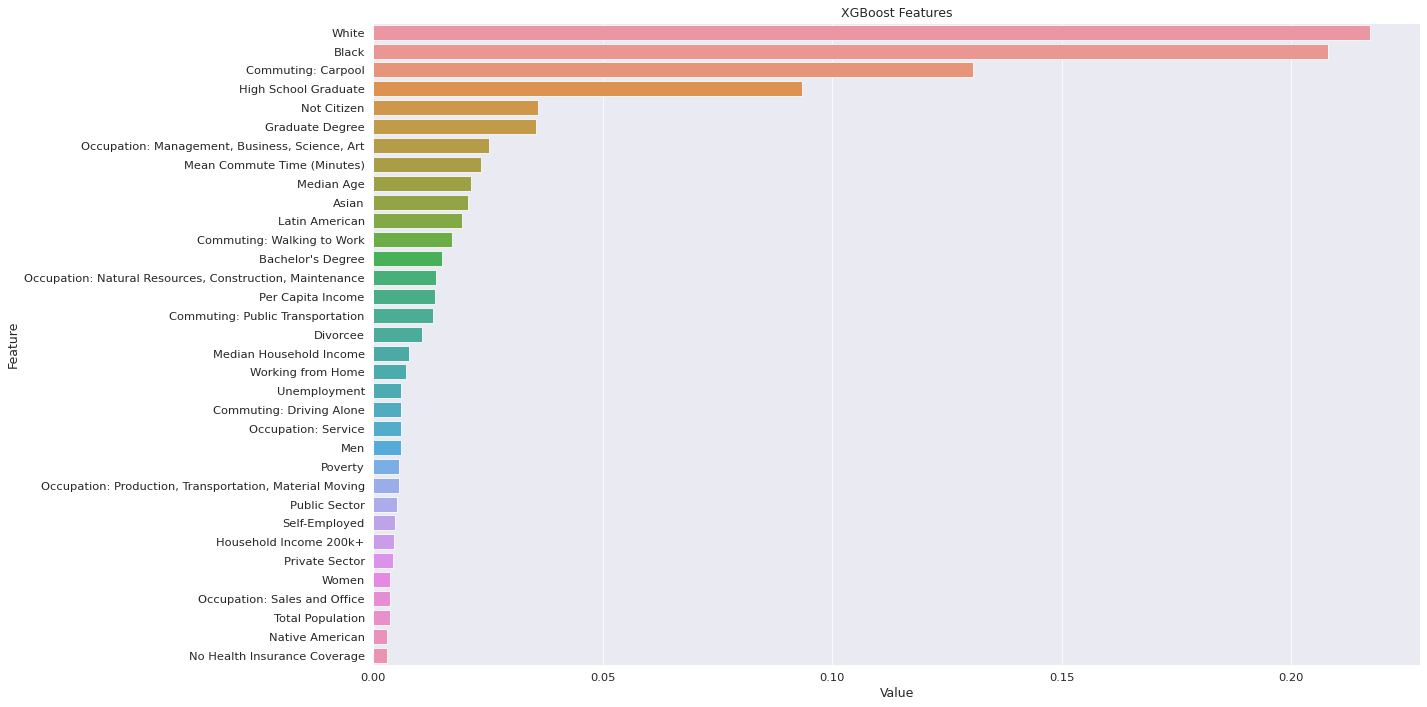

In [ ]:
feature_imp = pd.DataFrame(sorted(zip(xgbr.feature_importances_,X.columns)), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('XGBoost Features')
plt.tight_layout()
plt.show()

In [ ]:
lgbr = lgb.LGBMRegressor()

cv_scores_lgbr = cross_validate(lgbr)

train_scores_lgbr, test_scores_lgbr = model_training_and_testing(lgbr)

print_results(train_scores_lgbr, test_scores_lgbr, cv_scores_lgbr)

add_results_row('LGBMRegressor', test_scores_lgbr, cv_scores_lgbr)

Cross Validation Results:
-----------------------------------
Mean RMSE: 7.532256467093099
Min RMSE: 7.19247993182327
Max RMSE: 7.9933824481958675
-----------------------------------
Training set evaluation:
-----------------------------------
MAE: 2.8365400047423623
MSE: 14.311251557732902
RMSE: 3.7830214852327897
R2 Score: 0.9688266953229727
-----------------------------------
Test set evaluation:
-----------------------------------
MAE: 5.224616474582158
MSE: 58.3055005691238
RMSE: 7.635803858738371
R2 Score: 0.8647697155595719
-----------------------------------


In [ ]:
params_grid_lgb = {
    'n_estimators': [300, 700, 800, 900, 1000, 1500, 2000],
    'learning_rate': [0.03],
    'max_depth': [15],
    'num_leaves': [60],
    'min_data_in_leaf': [20],
    'min_gain_to_split': [0],
    'feature_fraction': [0.7],
    'bagging_fraction': [1],
    'lambda_l1': [0],
    'lambda_l2': [0],
    'seed': [0]
    }

fit_params_lgb = {"early_stopping_rounds": 30,
            "eval_metric" : "rmse", 
            "eval_set" : [(X_test, y_test)]}

lgbr = lgb.LGBMRegressor()

gs_lgb = GridSearchCV(lgbr, params_grid_lgb, scoring='neg_root_mean_squared_error', cv=kf, verbose=3, n_jobs=-1)

gs_lgb.fit(X_train, y_train, **fit_params_lgb)

print(gs_lgb.best_estimator_)
print(gs_lgb.best_score_)
print(gs_lgb.best_params_)

Fitting 5 folds for each of 7 candidates, totalling 35 fits
[1]	valid_0's l2: 410.786	valid_0's rmse: 20.2679
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l2: 391.797	valid_0's rmse: 19.7939
[3]	valid_0's l2: 373.732	valid_0's rmse: 19.3322
[4]	valid_0's l2: 356.334	valid_0's rmse: 18.8768
[5]	valid_0's l2: 340.074	valid_0's rmse: 18.4411
[6]	valid_0's l2: 324.177	valid_0's rmse: 18.0049
[7]	valid_0's l2: 309.884	valid_0's rmse: 17.6035
[8]	valid_0's l2: 295.969	valid_0's rmse: 17.2037
[9]	valid_0's l2: 283.267	valid_0's rmse: 16.8305
[10]	valid_0's l2: 270.852	valid_0's rmse: 16.4576
[11]	valid_0's l2: 259.372	valid_0's rmse: 16.105
[12]	valid_0's l2: 248.686	valid_0's rmse: 15.7698
[13]	valid_0's l2: 238.873	valid_0's rmse: 15.4555
[14]	valid_0's l2: 229.345	valid_0's rmse: 15.1442
[15]	valid_0's l2: 220.187	valid_0's rmse: 14.8387
[16]	valid_0's l2: 211.366	valid_0's rmse: 14.5384
[17]	valid_0's l2: 203.361	valid_0's rmse: 14.2605
[18]	valid_0's l2: 19

After tuning the parameters a bit more, we choose the following model model:

In [ ]:
lgbr = lgb.LGBMRegressor(feature_fraction=0.7, learning_rate=0.03, max_depth=15,
              min_data_in_leaf=20, n_estimators=900, num_leaves=60, importance_type='gain', seed=0)

eval_set = [(X_train, y_train), (X_test, y_test)]

lgbr.fit(X_train, y_train, eval_metric='rmse', eval_set=eval_set, verbose=False, early_stopping_rounds=30)
train_pred_lgbr = lgbr.predict(X_train)
test_pred_lgbr = lgbr.predict(X_test)
train_scores_lgbr = evaluate(y_train, train_pred_lgbr)
test_scores_lgbr = evaluate(y_test, test_pred_lgbr)

cv_scores_lgbr = cross_validate(lgbr)

print_results(train_scores_lgbr, test_scores_lgbr, cv_scores_lgbr)

add_results_row('LGBMRegressor (Optimized)', test_scores_lgbr, cv_scores_lgbr)

Cross Validation Results:
-----------------------------------
Mean RMSE: 7.404539589931152
Min RMSE: 6.980378697678808
Max RMSE: 7.843895185165282
-----------------------------------
Training set evaluation:
-----------------------------------
MAE: 1.0648228263219455
MSE: 2.377440795387676
RMSE: 1.5418951959804779
R2 Score: 0.9948213693283752
-----------------------------------
Test set evaluation:
-----------------------------------
MAE: 5.0017161282178195
MSE: 51.697651975311764
RMSE: 7.190107925150482
R2 Score: 0.8800955636555179
-----------------------------------


The result of the LGBM Regressor is slightly better than XGBoost. This model is also faster.

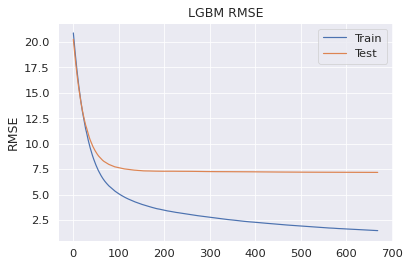

In [ ]:
lgbr_results = lgbr.evals_result_
epochs = len(lgbr_results['training']['rmse'])
x_axis = range(0, epochs)
fig, ax = plt.subplots()
ax.plot(x_axis, lgbr_results['training']['rmse'], label='Train')
ax.plot(x_axis, lgbr_results['valid_1']['rmse'], label='Test')
ax.legend()
plt.ylabel('RMSE')
plt.title('LGBM RMSE')
plt.show()

These are more or less the same features chosen by XGBoost, albeit with different weights. White is given much more weight in this model, almost twice as much as Black. In XGBoost, these two got similar weights.

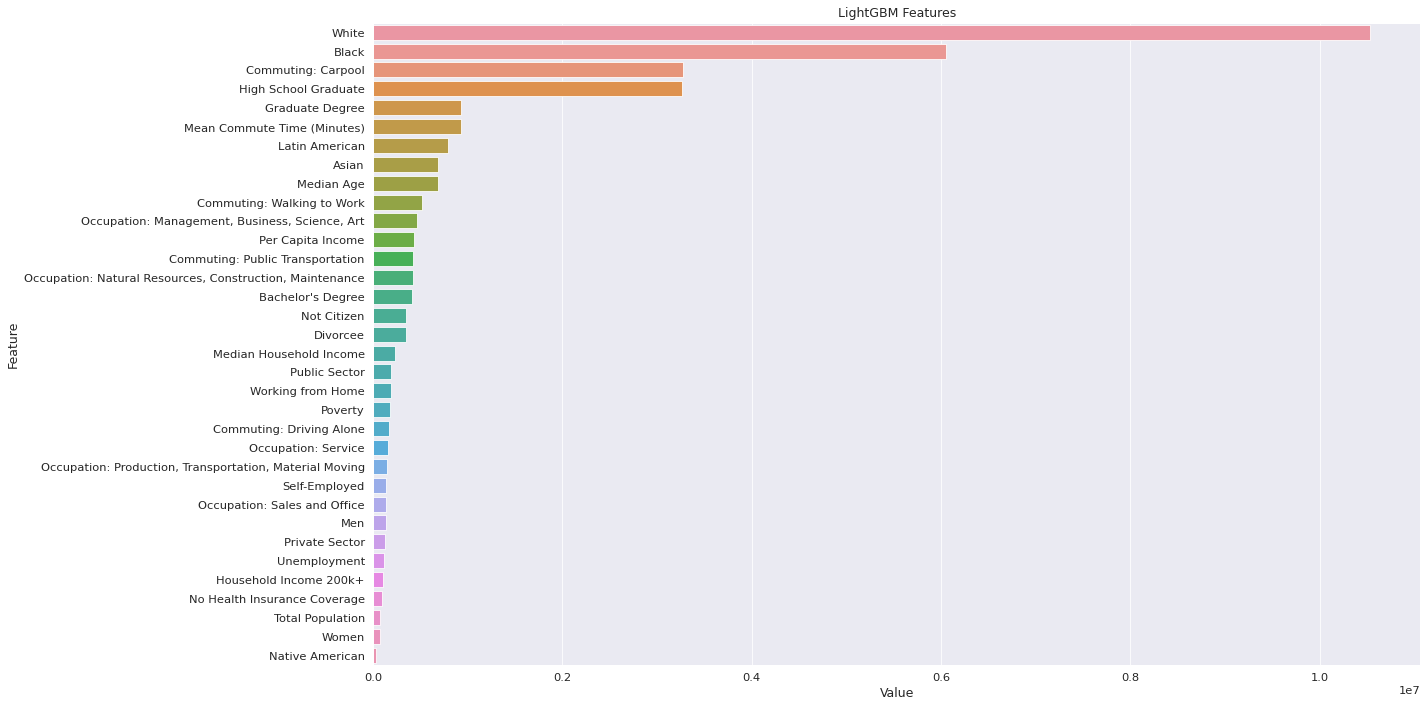

In [ ]:
feature_imp = pd.DataFrame(sorted(zip(lgbr.feature_importances_,X.columns)), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features')
plt.tight_layout()
plt.show()

LGBMRegressor has proved to be the most successful model, outperforming the XGBRegressor by a small margin. We will be working with it for the rest of this project.

In [ ]:
results_df

Model       MAE        MSE      RMSE  \
0                    Linear Regression  6.642501  82.708590  9.094426   
1              Random Forest Regressor  5.505517  63.381042  7.961221   
2  Random Forest Regressor (Optimized)  5.440074  62.810777  7.925325   
3                         XGBRegressor  5.653668  66.968028  8.183400   
4             XGBRegressor (Optimized)  5.065002  52.530294  7.247779   
5                        LGBMRegressor  5.224616  58.305501  7.635804   
6            LGBMRegressor (Optimized)  5.001716  51.697652  7.190108   

         R2  CV (Mean)  CV (Min)  CV (Max)  
0  0.808171   9.092323  8.412458  9.825300  
1  0.852998   8.014868  7.548871  8.539537  
2  0.854320   7.998255  7.512401  8.472508  
3  0.844678   8.081426  7.607095  8.548482  
4  0.878164   7.357023  7.062809  7.802732  
5  0.864770   7.532256  7.192480  7.993382  
6  0.880096   7.404540  6.980379  7.843895

The results are not perfect, but they are not bad either, and they do give an indication of the voting behavior. Plotting the predicted and the true values, we can see that the model is more accurate in regions with a very high population of Democratic voters. In "swing tracts" or "red tracts" the margin of error is larger.

The reason for this may be our data. That is, the socio-demographic composition of New York and the fact that the state is a Democratic bastion.

In [ ]:
def scatterplot_predictions(true_vals, predictions, title=None):
  plt.figure(figsize=(10,10))
  plt.title(title, fontsize=15)
  plt.scatter(true_vals, predictions, c='crimson')

  p1 = max(max(predictions), max(true_vals))
  p2 = min(min(predictions), min(true_vals))
  plt.plot([p1, p2], [p1, p2], 'b-')
  plt.xlabel('True Values', fontsize=15)
  plt.ylabel('Predictions', fontsize=15)
  plt.axis('equal')
  plt.show()

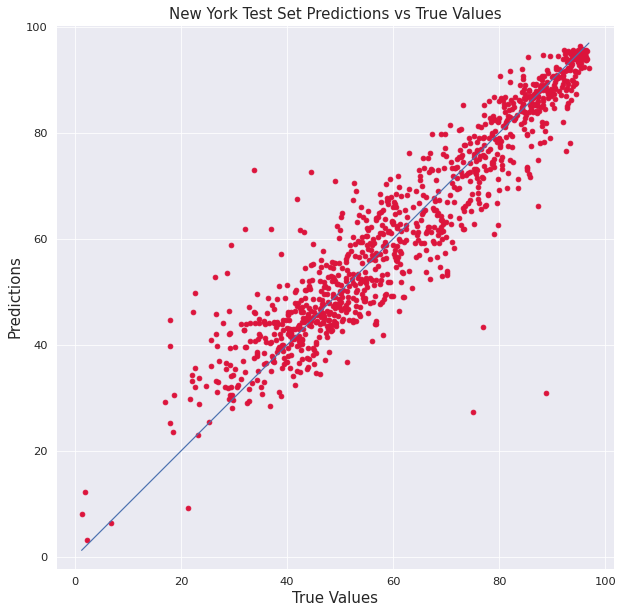

In [ ]:
scatterplot_predictions(y_test, test_pred_lgbr, 'New York Test Set Predictions vs True Values')

# Testing the Model: California, Texas, and Florida

How accurately can our model predict election results using the same data from a different state? Is it generalizable to other states or specifically tailored to the State of New York?

Let's try our model in an extra test, using data from California, Texas, and Florida. California is a blue state, just like New York; Texas is a red state, but many people believe that it will become a battleground state in the near future. In contrast to Texas, Florida is a battleground state that seems to be becoming red.

In [ ]:
path = "/content/drive/MyDrive/Colab Notebooks/US Census/Data/Preprocessed Data/california_data.csv"

# We pass the dtype argument to prevent the geographic code columns becoming integers, thereby removing the leading zeros.
california_df = pd.read_csv(path, dtype={'State': str, 'County': str, 'Tract': str, 'FIPS': str}) 
cali_df = california_df[california_df['Total Population'] > 0]

In [ ]:
X_california = cali_df._get_numeric_data()
y_california = cali_df['Democrat']
X_california.drop(['Democrat', 'Republican'], axis=1, inplace=True)

X_california[numeric_cols] = sc.fit_transform(X_california[numeric_cols])

In [ ]:
predictions_california = lgbr.predict(X_california)
scores_california = evaluate(y_california, predictions_california)

print_evaluation(*scores_california)

MAE: 9.144002738825618
MSE: 138.93991742884188
RMSE: 11.787277778556076
R2 Score: 0.4111800912138258
-----------------------------------


Considering that the socio-demographic composition and voting patterns of each state are different, these are not terrible results! The fact that New York is a blue state, just like California, may be contributing to this result.

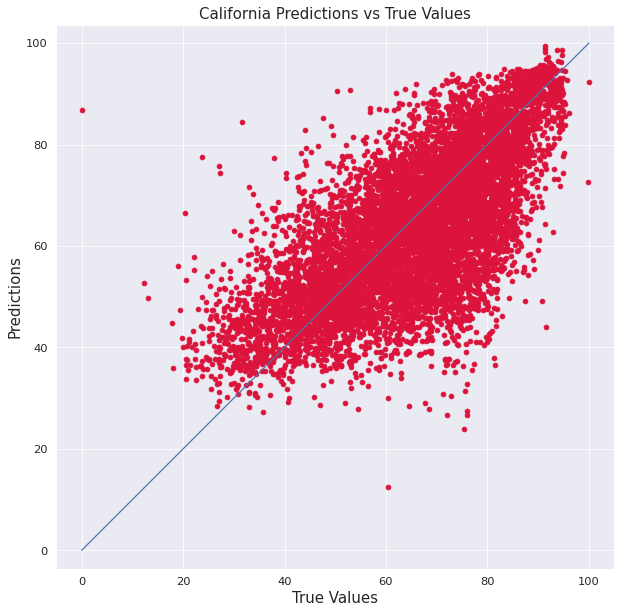

In [ ]:
scatterplot_predictions(y_california, predictions_california, 'California Predictions vs True Values')

In [ ]:
path = "/content/drive/MyDrive/Colab Notebooks/US Census/Data/Preprocessed Data/texas_data.csv"

# We pass the dtype argument to prevent the geographic code columns becoming integers, thereby removing the leading zeros.
texas_df = pd.read_csv(path, dtype={'State': str, 'County': str, 'Tract': str, 'FIPS': str}) 
tx_df = texas_df[texas_df['Total Population'] > 0]

In [ ]:
X_texas = tx_df._get_numeric_data()
y_texas = tx_df['Democrat']
X_texas.drop(['Democrat', 'Republican'], axis=1, inplace=True)

X_texas[numeric_cols] = sc.fit_transform(X_texas[numeric_cols])

In [ ]:
predictions_texas = lgbr.predict(X_texas)
scores_texas = evaluate(y_texas, predictions_texas)

print_evaluation(*scores_texas)

MAE: 19.869074377058055
MSE: 612.1714967690069
RMSE: 24.74209968391945
R2 Score: -0.3326644148095981
-----------------------------------


In the case of Texas, the results are simply catastrophic — the model hasn't identified any pattern. Although we could have expected slightly better results, they are still not that surprising.

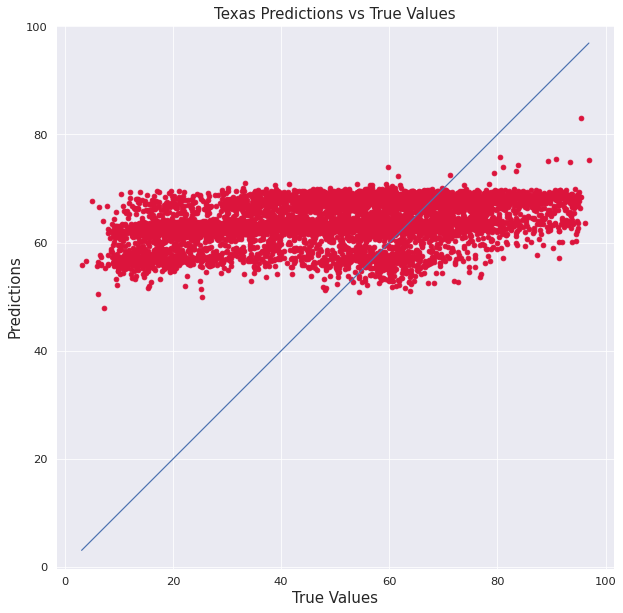

In [ ]:
scatterplot_predictions(y_texas, predictions_texas, 'Texas Predictions vs True Values')

In [ ]:
path = "/content/drive/MyDrive/Colab Notebooks/US Census/Data/Preprocessed Data/florida_data.csv"

# We pass the dtype argument to prevent the geographic code columns becoming integers, thereby removing the leading zeros.
florida_df = pd.read_csv(path, dtype={'State': str, 'County': str, 'Tract': str, 'FIPS': str}) 
fl_df = florida_df[florida_df['Total Population'] > 0]

In [ ]:
X_florida = fl_df._get_numeric_data()
y_florida = fl_df['Democrat']
X_florida.drop(['Democrat', 'Republican'], axis=1, inplace=True)

X_florida[numeric_cols] = sc.fit_transform(X_florida[numeric_cols])

In [ ]:
predictions_florida = lgbr.predict(X_florida)
scores_florida = evaluate(y_florida, predictions_florida)

print_evaluation(*scores_florida)

MAE: 13.844412175824525
MSE: 280.69990487240824
RMSE: 16.754101135913206
R2 Score: 0.004280870319443797
-----------------------------------


The Florida results are not good, yet they are not as bad as Texas.

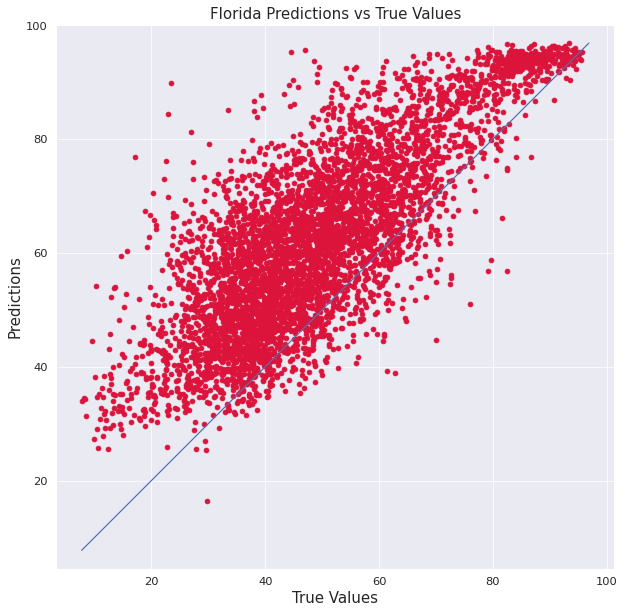

In [ ]:
scatterplot_predictions(y_florida, predictions_florida, 'Florida Predictions vs True Values')

# Conclusion

In this project, we have built a model that forecasts voting behavior in the State of New York by analyzing socio-demographic data of census tracts. As expected, the factors that contributed the most to the model are related to race, commute, and education; and the result was not bad at all!

While the model performance in New York was fine, we have seen that it is not really generalizable to other states. As each state has a different socio-demographic composition and voting behavior, it was rather expected that a model that had been trained on New York data would perform poorly in this task. In addition, there is a clear bias towards higher percentages of Democratic vote — probably due to the fact that New York is a blue state. For these reasons, the results on California were not good, but not terrible; the results on Texas were horrible; and Florida was somewhere in between. Choosing blue states with a similar socio-demographic composition to New York for prediction could have yielded better results.

There is much more one can do to analyze and predict voting behavior in the US: using census data with different geographic entities, analyzing more states, or drawing on more election results from previous years and different levels (president, Senate, House of Representatives, etc.) to analyze trends and differences.